<a href="https://colab.research.google.com/github/NadaTiyasa/Bengkod_NadaTiyasa_14217/blob/main/Bengkod_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nada Tiyasa Salsabela (A11.2022.14217)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [2]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ObesityDataSet.csv')

Mounted at /content/drive


# 1. Exploratory Data Analysis (EDA)

In [3]:
# =========================================================================
#       Tampilan beberapa baris pertama dan informasi umum dataset
# =========================================================================
print("<3<3<3 Beberapa Baris Pertama <3<3<3")
print(df.head())
print("\n<3<3<3 Dimensi Dataset <3<3<3")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\n<3<3<3 Deskripsi Statistik Dataset <3<3<3")
print(df.describe(include='all'))
print("\n<3<3<3 Tipe Data Setiap Kolom <3<3<3")
print(df.dtypes)

<3<3<3 Beberapa Baris Pertama <3<3<3
  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1    

In [4]:
# =========================================================================
#             Cek Missing Value, Duplikat, dan Nilai Unik
# =========================================================================
print("\n<3<3<3 Jumlah Missing Values Tiap Kolom <3<3<3")
print(df.isnull().sum())
print("\n<3<3<3 Jumlah Duplikat <3<3<3")
print(df.duplicated().sum())
print("\n<3<3<3 Jumlah Nilai Unik Tiap Kolom <3<3<3")
print(df.nunique())


<3<3<3 Jumlah Missing Values Tiap Kolom <3<3<3
Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64

<3<3<3 Jumlah Duplikat <3<3<3
18

<3<3<3 Jumlah Nilai Unik Tiap Kolom <3<3<3
Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 

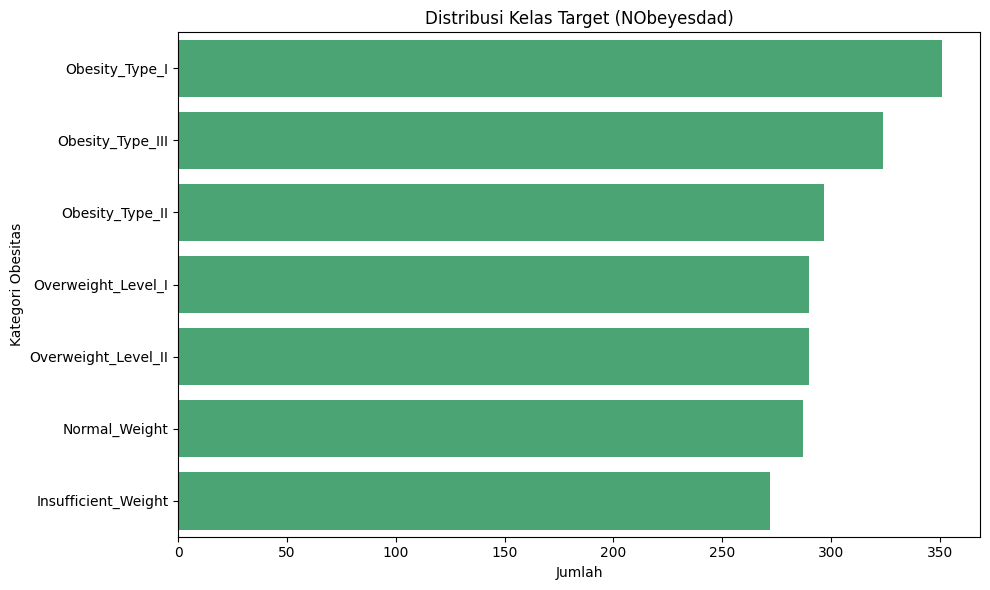

In [5]:
# =========================================================================
#                   Visualisasi Distribusi Kelas Target
# =========================================================================
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='NObeyesdad', order=df['NObeyesdad'].value_counts().index, color='mediumseagreen')
plt.title('Distribusi Kelas Target (NObeyesdad)')
plt.xlabel('Jumlah')
plt.ylabel('Kategori Obesitas')
plt.tight_layout()
plt.show()

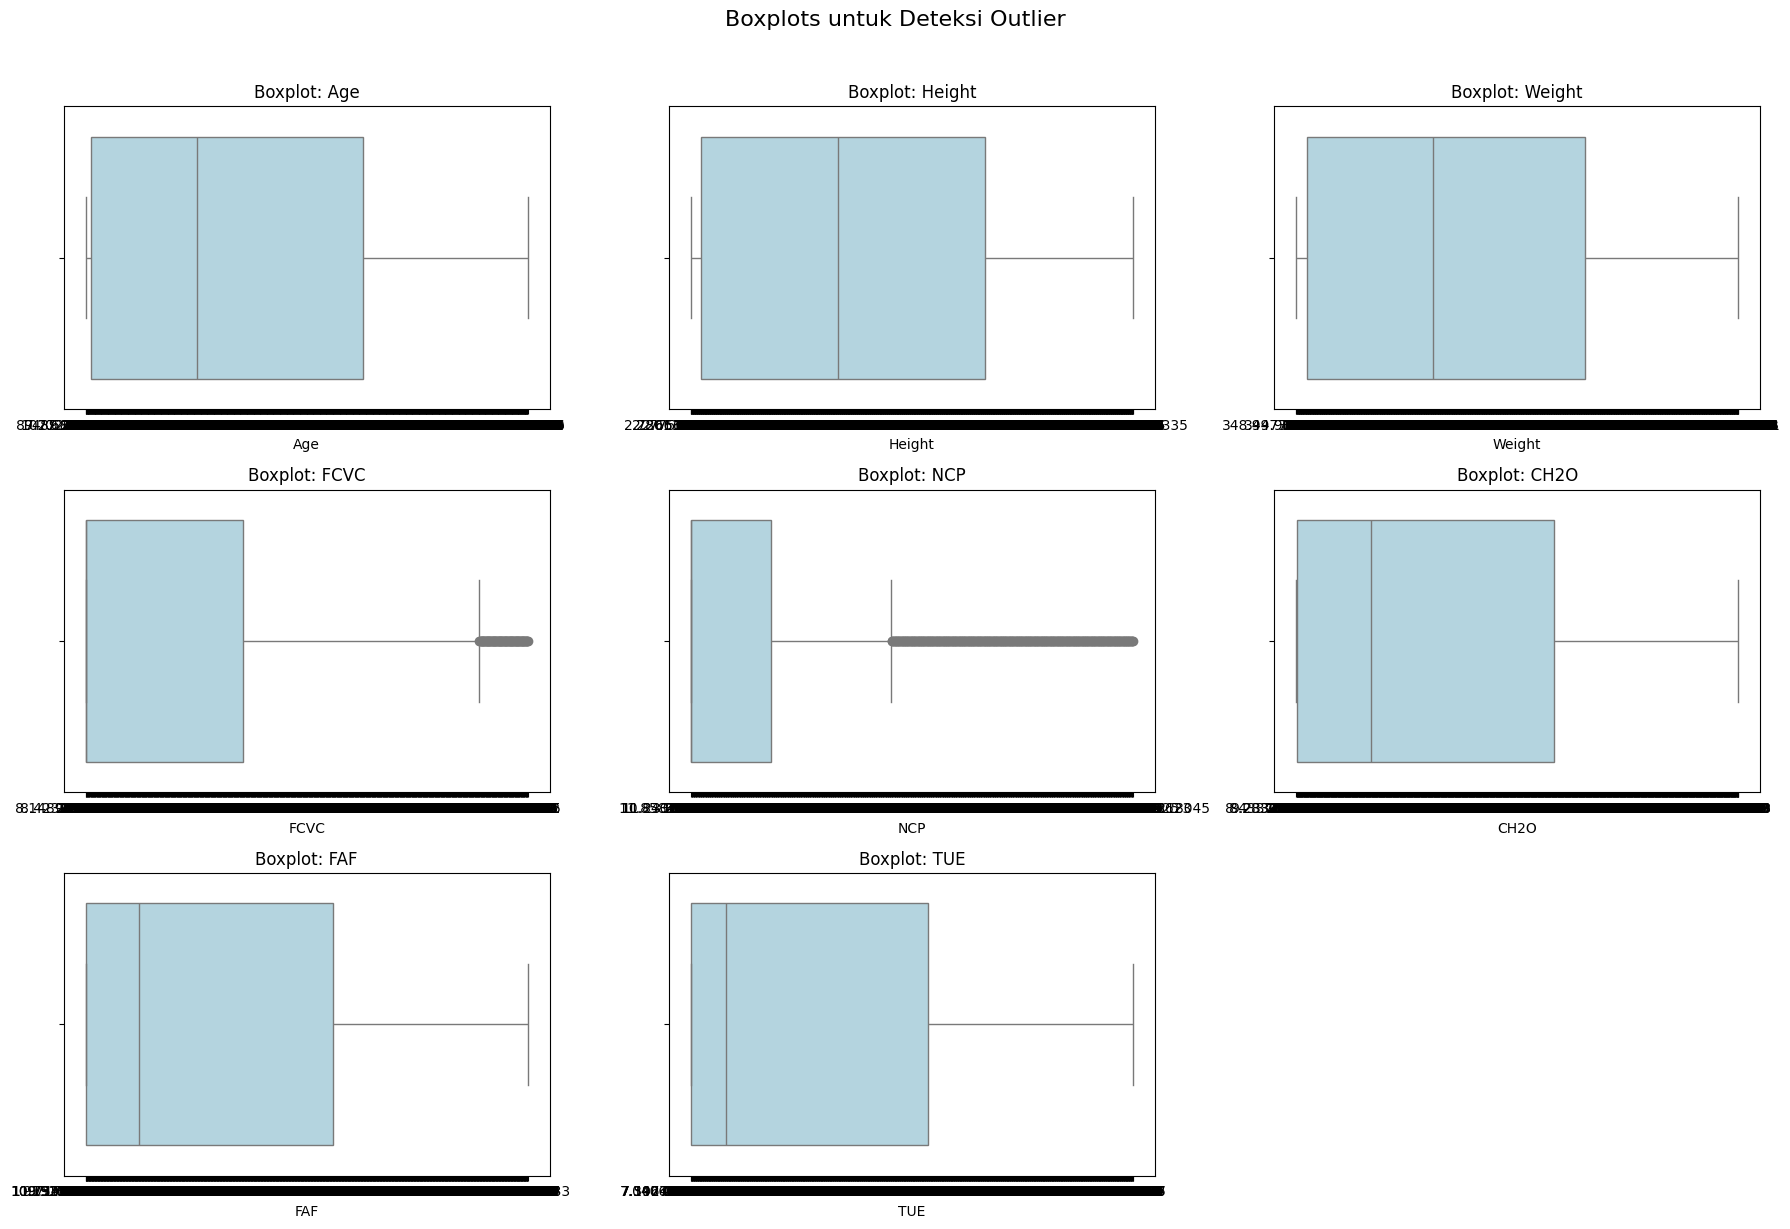

In [6]:
# =========================================================================
#                     Boxplot untuk Deteksi Outlier
# =========================================================================
numeric_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.suptitle('Boxplots untuk Deteksi Outlier', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Dataset obesitas terdiri dari 2.111 baris dan 17 kolom dengan 7 kategori pada target NObeyesdad, didominasi oleh Obesity_Type_I. Terdapat missing values di hampir semua kolom, serta 18 data duplikat yang perlu dihapus. Beberapa kolom numerik masih bertipe objek karena format penulisan tidak konsisten. Dataset juga menunjukkan adanya outlier, terutama pada kolom NCP, FCVC, FAF, dan TUE, yang perlu ditangani untuk menjaga kualitas pemodelan. Secara keseluruhan, dataset memerlukan pembersihan lanjutan sebelum digunakan dalam machine learning.









# 2. Preprocessing Data

In [7]:
print("Daftar kolom dalam DataFrame:")
print(df.columns.tolist())

Daftar kolom dalam DataFrame:
['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS', 'NObeyesdad']


In [8]:
# =========================================================================
# Tangani missing values, error, duplikasi, dan outlier di setiap kolom.
# =========================================================================
df = df.copy()
numeric_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

# Ganti koma jadi titik, ubah '?' jadi NaN, ubah ke float
for col in numeric_columns:
    df[col] = df[col].astype(str).str.replace(",", ".", regex=False)
    df[col] = df[col].replace("?", np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Tampilkan jumlah missing value setelah konversi
print("Missing values setelah konversi:")
print(df[numeric_columns].isnull().sum())

# Hapus duplikat
df = df.drop_duplicates()

# Isi missing values: median untuk numerik, mode untuk kategorikal
for col in df.columns:
    if df[col].dtype == object:
        mode_val = df[col].mode()[0]
        df.loc[:, col] = df[col].fillna(mode_val)
    else:
        median_val = df[col].median()
        df.loc[:, col] = df[col].fillna(median_val)

# Fungsi hapus outlier dengan IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Terapkan outlier removal untuk setiap kolom numerik
for col in numeric_columns:
    df = remove_outliers(df, col).copy()  # .copy() untuk mencegah warning pada loop selanjutnya

# Tampilkan hasil akhir
print("\nJumlah data setelah pembersihan:", df.shape)
print("\nContoh 5 data teratas:")
print(df.head())

Missing values setelah konversi:
Age       22
Height    22
Weight    19
FCVC      18
NCP       22
CH2O      15
FAF       19
TUE       15
dtype: int64

Jumlah data setelah pembersihan: (1317, 17)

Contoh 5 data teratas:
    Age  Gender  Height  Weight        CALC FAVC  FCVC  NCP  SCC SMOKE  CH2O  \
0  21.0  Female    1.62    64.0          no   no   2.0  3.0   no    no   2.0   
1  21.0  Female    1.52    56.0   Sometimes   no   3.0  3.0  yes   yes   3.0   
2  23.0    Male    1.80    77.0  Frequently   no   2.0  3.0   no    no   2.0   
3  27.0    Male    1.80    87.0  Frequently   no   3.0  3.0   no    no   2.0   
5  29.0    Male    1.62    53.0   Sometimes  yes   2.0  3.0   no    no   2.0   

  family_history_with_overweight  FAF  TUE       CAEC                 MTRANS  \
0                            yes  0.0  1.0  Sometimes  Public_Transportation   
1                            yes  3.0  0.0  Sometimes  Public_Transportation   
2                            yes  2.0  1.0  Sometimes  Publi

In [9]:
# =========================================================================
#                     Ubah data kategori menjadi numerik
# =========================================================================
target_col = "NObeyesdad" # Tentukan kolom target

# Ambil kolom kategorikal selain target
cat_cols = [col for col in df.select_dtypes(include='object').columns if col != target_col]

# Label encode semua fitur kategorikal
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Label encode target
target_encoder = LabelEncoder()
df[target_col] = target_encoder.fit_transform(df[target_col])

# Simpan hasil ke df_cleaned
df_cleaned = df.copy()

# Distribusi kelas target (dalam persentase)
class_distribution = df_cleaned[target_col].value_counts(normalize=True)

# ==================== Tampilkan Ringkasan ====================
print(" Ukuran dataset setelah preprocessing:", df_cleaned.shape)
print("\n Jumlah nilai kosong per kolom:")
print(df_cleaned.isnull().sum())

print("\n Distribusi kelas target (dalam persentase):")
print(class_distribution)


 Ukuran dataset setelah preprocessing: (1317, 17)

 Jumlah nilai kosong per kolom:
Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

 Distribusi kelas target (dalam persentase):
NObeyesdad
4    0.238421
3    0.153379
1    0.143508
2    0.142749
6    0.119210
5    0.105543
0    0.097191
Name: proportion, dtype: float64


In [10]:
# =========================================================================
#             Tentukan apakah semua feature perlu digunakan.
# =========================================================================
correlation = df.corr(numeric_only=True)["NObeyesdad"].sort_values(ascending=False)
print("Korelasi fitur dengan target:")
print(correlation)

# Buang fitur dengan korelasi rendah / NaN
drop_cols = ["SMOKE", "MTRANS", "TUE"]
df = df.drop(columns=drop_cols, errors='ignore')

# Pisahkan fitur dan target
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

Korelasi fitur dengan target:
NObeyesdad                        1.000000
Weight                            0.391996
family_history_with_overweight    0.328130
CAEC                              0.279007
Age                               0.253998
CH2O                              0.111247
FCVC                              0.105149
FAVC                              0.080324
MTRANS                           -0.003981
Height                           -0.009105
SMOKE                            -0.035481
TUE                              -0.051704
Gender                           -0.056229
SCC                              -0.104117
FAF                              -0.143359
NCP                              -0.154478
CALC                             -0.168834
Name: NObeyesdad, dtype: float64


In [11]:
# =========================================================================
#           Atasi ketidakseimbangan kelas data menggunakan SMOTE
# =========================================================================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Tampilkan distribusi kelas sebelum dan sesudah SMOTE
print("\nDistribusi kelas sebelum SMOTE:")
print(pd.Series(y).value_counts())
print("\nDistribusi kelas sesudah SMOTE:")
print(pd.Series(y_resampled).value_counts())


Distribusi kelas sebelum SMOTE:
NObeyesdad
4    314
3    202
1    189
2    188
6    157
5    139
0    128
Name: count, dtype: int64

Distribusi kelas sesudah SMOTE:
NObeyesdad
1    314
5    314
2    314
6    314
3    314
0    314
4    314
Name: count, dtype: int64


In [12]:
# =========================================================================
#                           Standarisasi data.
# =========================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

Dari hasil preprocessing dataset ini, dapat disimpulkan bahwa data sudah bersih dari nilai kosong setelah penanganan missing values dan konversi numerik. Dataset yang semula memiliki 17 kolom berhasil disederhanakan menjadi 12 fitur relevan dengan menghapus fitur yang korelasinya rendah terhadap target. Distribusi kelas target yang awalnya tidak seimbang berhasil diseimbangkan menggunakan SMOTE, sehingga setiap kelas memiliki jumlah data yang sama yaitu 314 sampel. Proses ini penting untuk menghindari bias model terhadap kelas mayoritas. Korelasi fitur menunjukkan bahwa fitur seperti berat badan (Weight), riwayat keluarga dengan overweight, dan beberapa variabel lain memiliki kontribusi positif terhadap target obesitas, sementara fitur seperti jenis kelamin, aktivitas fisik, dan pola makan memiliki korelasi negatif.

# 3. Pemodelan dan Evaluasi

In [13]:
# =========================================================================
#                  Split data menjadi data latih dan data uji
# =========================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [14]:
# =========================================================================
#             Pemodelan dengan 5 algoritma klasifikasi
# =========================================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

results = []
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

    # Simpan confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

In [15]:
# =========================================================================
#                Tampilkan hasil evaluasi model dalam tabel
# =========================================================================
results_df = pd.DataFrame(results)
print("\nHasil Evaluasi Model:")
print(results_df)


Hasil Evaluasi Model:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.829545   0.829772  0.829545  0.826827
1        Random Forest  0.963636   0.966180  0.963636  0.964138
2                  SVM  0.868182   0.875093  0.868182  0.869762
3                  KNN  0.815909   0.820968  0.815909  0.816874
4              XGBoost  0.981818   0.982024  0.981818  0.981834


<Figure size 600x400 with 0 Axes>

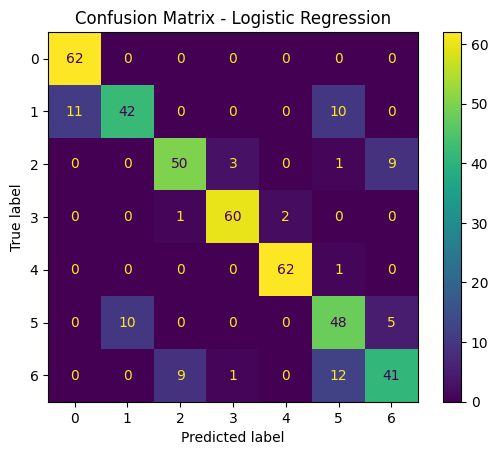

<Figure size 600x400 with 0 Axes>

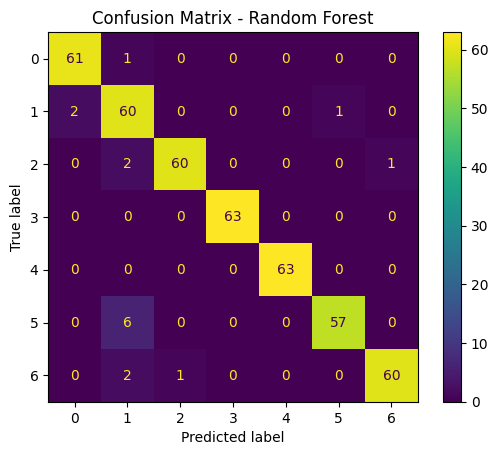

<Figure size 600x400 with 0 Axes>

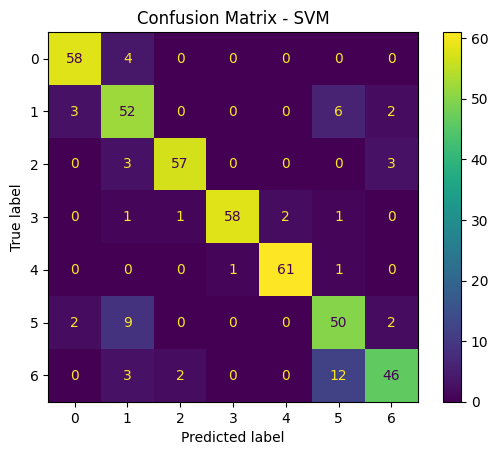

<Figure size 600x400 with 0 Axes>

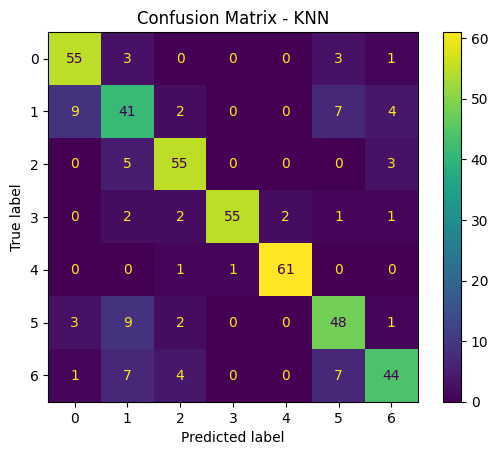

<Figure size 600x400 with 0 Axes>

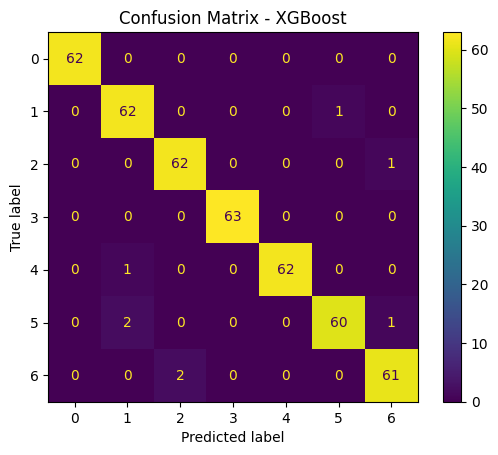

In [16]:
# =========================================================================
#              Visualisasi confusion matrix untuk tiap model
# =========================================================================
for name, cm in conf_matrices.items():
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.show()

<Figure size 1200x600 with 0 Axes>

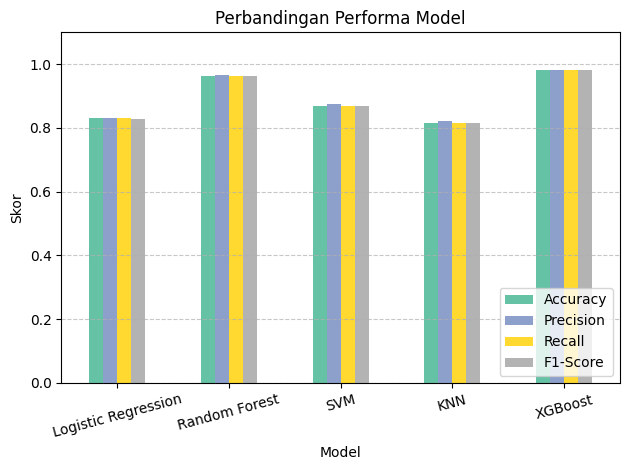

In [17]:
# =========================================================================
#        Visualisasi perbandingan akurasi, presisi, recall, dan F1
# =========================================================================
plt.figure(figsize=(12, 6))
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(kind="bar", colormap="Set2")
plt.title("Perbandingan Performa Model")
plt.ylabel("Skor")
plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=15)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [18]:
# =========================================================================
#                          Kesimpulan akhir
# =========================================================================
best_model = results_df.sort_values("F1-Score", ascending=False).iloc[0]
print(
    f"Model terbaik : {best_model['Model']} dengan F1-Score sebesar "
    f"{best_model['F1-Score']:.2f}"
)

Model terbaik : XGBoost dengan F1-Score sebesar 0.98


Berdasarkan evaluasi, model terbaik adalah *XGBoost* dengan F1-Score sebesar 0.98. Model ini menunjukkan performa yang optimal dan seimbang pada data obesitas yang telah diolah, dan direkomendasikan untuk digunakan sebagai model klasifikasi akhir.

# 4. Hyperparameter Tuning

In [19]:
# =========================================================================
#                       Definisikan parameter grid
# =========================================================================
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "lbfgs"]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1]
    }
}

# Model dasar (sebelum tuning)
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

In [20]:
# =========================================================================
#                 Lakukan GridSearchCV untuk semua model
# =========================================================================
best_models = {}
tuned_results = []

for name, model in base_models.items():
    print(f"🔍 Tuning model: {name}")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    tuned_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })


🔍 Tuning model: Logistic Regression
🔍 Tuning model: Random Forest
🔍 Tuning model: SVM
🔍 Tuning model: KNN
🔍 Tuning model: XGBoost


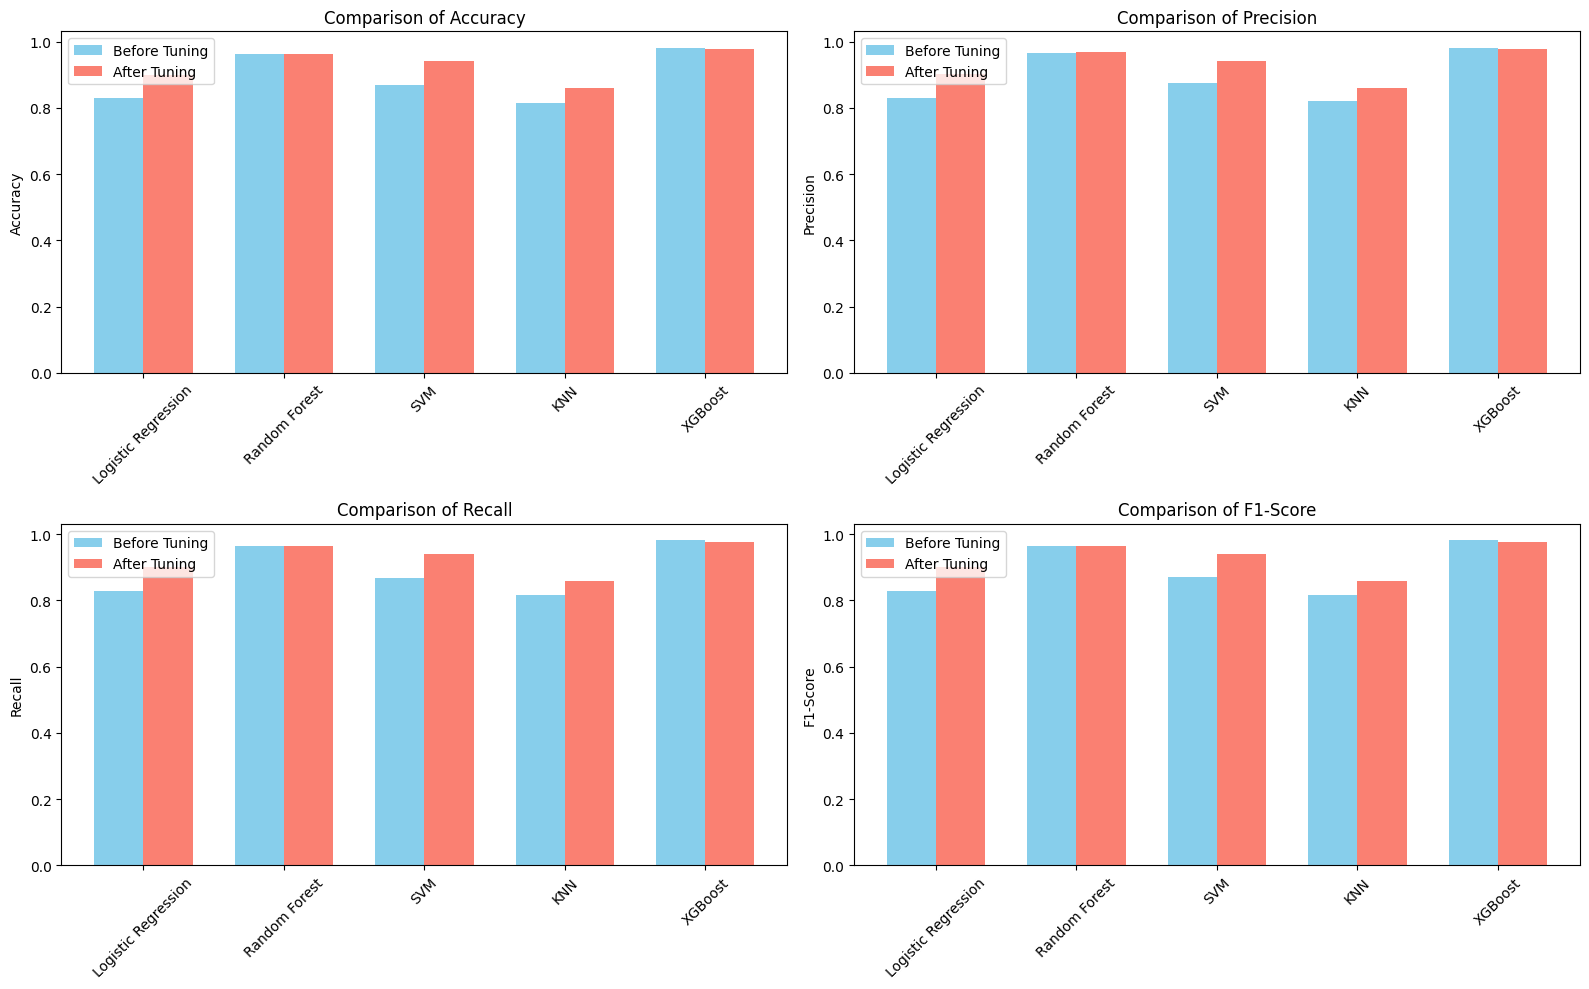

In [21]:
# =========================================================================
#                 Visualisasi perbandingan performa model
# =========================================================================
import pandas as pd

# Buat DataFrame hasil sebelum dan sesudah tuning
before_df = pd.DataFrame(results).set_index("Model")
after_df = pd.DataFrame(tuned_results).set_index("Model")

# Plot
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

for i, metric in enumerate(metrics):
    x = np.arange(len(before_df.index))  # posisi untuk bar
    width = 0.35  # lebar bar

    axs[i].bar(x - width/2, before_df[metric], width, label="Before Tuning", color='skyblue')
    axs[i].bar(x + width/2, after_df[metric], width, label="After Tuning", color='salmon')

    axs[i].set_title(f"Comparison of {metric}")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(before_df.index, rotation=45)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [22]:
# =========================================================================
#                                 KESIMPULAN
# =========================================================================
print("\n🎯 Performa Sebelum Tuning:")
print(before_df)

print("\n🚀 Performa Setelah Tuning:")
print(after_df)


🎯 Performa Sebelum Tuning:
                     Accuracy  Precision    Recall  F1-Score
Model                                                       
Logistic Regression  0.829545   0.829772  0.829545  0.826827
Random Forest        0.963636   0.966180  0.963636  0.964138
SVM                  0.868182   0.875093  0.868182  0.869762
KNN                  0.815909   0.820968  0.815909  0.816874
XGBoost              0.981818   0.982024  0.981818  0.981834

🚀 Performa Setelah Tuning:
                     Accuracy  Precision    Recall  F1-Score
Model                                                       
Logistic Regression  0.900000   0.900857  0.900000  0.899626
Random Forest        0.963636   0.967939  0.963636  0.964385
SVM                  0.940909   0.941888  0.940909  0.940606
KNN                  0.859091   0.861111  0.859091  0.858893
XGBoost              0.977273   0.977546  0.977273  0.977268


XGBoost adalah model terbaik dalam studi ini, dengan performa paling konsisten dan tertinggi, baik sebelum maupun setelah tuning. Namun, tuning sangat penting untuk Logistic Regression, SVM, dan KNN, karena memberikan peningkatan signifikan terhadap performa mereka.

# Deployment

In [23]:
# Simpan scaler (untuk normalisasi data saat prediksi)
joblib.dump(scaler, "scaler.pkl")

# Simpan encoder target
joblib.dump(target_encoder, "label_encoder.pkl")

# Gunakan informasi model terbaik dari hasil evaluasi
best_model_info = results_df.sort_values("F1-Score", ascending=False).iloc[0]
best_model_name = best_model_info["Model"]

# Ambil model terbaik dari hasil tuning
model_terbaik = best_models[best_model_name]

# Simpan model terbaik
joblib.dump(model_terbaik, "model.pkl")

# Cek file dan unduh
import os
print(os.listdir())
print(os.path.exists("model.pkl"))  # Harusnya True

from google.colab import files
files.download("model.pkl")

['.config', 'model.pkl', 'scaler.pkl', 'drive', 'label_encoder.pkl', 'sample_data']
True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
X.columns.tolist() #cek urutan input data

['Age',
 'Gender',
 'Height',
 'Weight',
 'CALC',
 'FAVC',
 'FCVC',
 'NCP',
 'SCC',
 'CH2O',
 'family_history_with_overweight',
 'FAF',
 'CAEC']